# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.

# Code

In [1]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product: score computation
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



In [4]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)

## Parameter setting for model comparative:

Patience is a paramater determining the earlystopping of the fitting model on this algorithm for the training process. Initial value is set at `patience = 3`, and by considering 50 `epochs` and all the fixed parameters we get `PREDICTION ACCURACY (%) - Train: 57.710, Test: 57.015`. Changing this value to 40 we obtain the following: `PREDICTION ACCURACY (%): Train: 55.407, Test: 54.965`, it is not worth it to early stop. For `patience = 100`, we get `PREDICTION ACCURACY (%): Train: 48.581, Test: 47.940`.

Sometimes when setting the `patience=3` the model stops at low epochs, getting low accuracy results, such as 

`General: 32 epochs, Train: 32.067, Test: 31.970`

`Badhanau: 38 epochs, Train: 40.958, Test: 40.290`

`General Luong: 38 epochs. Train: 29.120, Test: 28.595`

Setting upper epochs: such as `epoch = 100` and `patience=30`, we get `General: Train: 90.074, Test: 89.910`

TRying highier epochs with a more reasonable patience parameter on the subsequent studies. 

When setting highier values of the epochs more patience is needed.

Also trying different values of the model's parameters such as the rnn units or the batch size:

2022-12-26 19:38:10.668214: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-12-26 19:39:54.411082: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 149s 2s/step - loss: 2.9660 - accuracy: 0.0568 - val_loss: 2.9488 - val_accuracy: 0.0554
Epoch 2/200
18/18 [==============================] - 5s 278ms/step - loss: 2.9441 - accuracy: 0.0594 - val_loss: 2.9419 - val_accuracy: 0.0641
Epoch 3/200
18/18 [==============================] - 5s 285ms/step - loss: 2.9391 - accuracy: 0.0643 - val_loss: 2.9372 - val_accuracy: 0.0675
Epoch 4/200
18/18 [==============================] - 5s 279ms/step - loss: 2.9288 - accuracy: 0.0740 - val_loss: 2.9242 - val_accuracy: 0.0772
Epoch 5/200
18/18 [==============================] - 5s 279ms/step - loss: 2.9203 - accuracy: 0.0781 - val_loss: 2.9216 - val_accuracy: 0.0774
Epoch 6/200
18/18 [==============================] - 5s 279ms/step - loss: 2.9134 - accuracy: 0.0819 - val_loss: 2.9123 - val_accuracy: 0.0819
Epoch 7/200
18/18 [==============================] - 5s 284ms/step - loss: 2.9049 - accuracy: 0.0867 - val_loss: 2.9032 - val_accuracy: 0.0874
Epoch 8/200


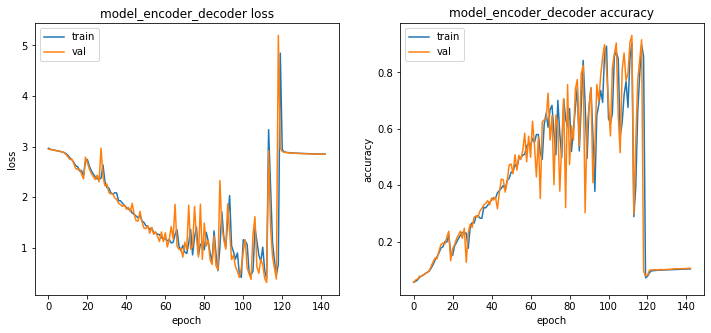

In [4]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=30)

Epoch 1/200
36/36 [==============================] - 145s 1s/step - loss: 2.9555 - accuracy: 0.0539 - val_loss: 2.9460 - val_accuracy: 0.0517
Epoch 2/200
36/36 [==============================] - 8s 215ms/step - loss: 2.9412 - accuracy: 0.0659 - val_loss: 2.9339 - val_accuracy: 0.0672
Epoch 3/200
36/36 [==============================] - 8s 223ms/step - loss: 2.9255 - accuracy: 0.0747 - val_loss: 2.9212 - val_accuracy: 0.0789
Epoch 4/200
36/36 [==============================] - 8s 214ms/step - loss: 2.9130 - accuracy: 0.0829 - val_loss: 2.9044 - val_accuracy: 0.0856
Epoch 5/200
36/36 [==============================] - 8s 215ms/step - loss: 2.8915 - accuracy: 0.0912 - val_loss: 2.8793 - val_accuracy: 0.0963
Epoch 6/200
36/36 [==============================] - 7s 207ms/step - loss: 2.8647 - accuracy: 0.1026 - val_loss: 2.8346 - val_accuracy: 0.1126
Epoch 7/200
36/36 [==============================] - 8s 210ms/step - loss: 2.7741 - accuracy: 0.1349 - val_loss: 2.7161 - val_accuracy: 0.1497


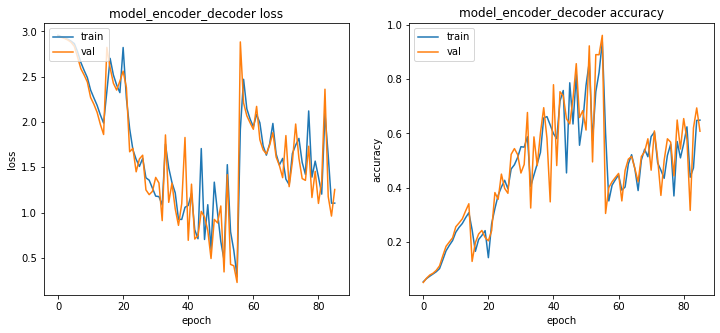

In [5]:
# training parameters
batch_size = 50

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=30)

Epoch 1/200
18/18 [==============================] - 145s 2s/step - loss: 2.9597 - accuracy: 0.0556 - val_loss: 2.9458 - val_accuracy: 0.0543
Epoch 2/200
18/18 [==============================] - 7s 376ms/step - loss: 2.9447 - accuracy: 0.0570 - val_loss: 2.9424 - val_accuracy: 0.0621
Epoch 3/200
18/18 [==============================] - 7s 374ms/step - loss: 2.9407 - accuracy: 0.0648 - val_loss: 2.9425 - val_accuracy: 0.0606
Epoch 4/200
18/18 [==============================] - 7s 375ms/step - loss: 2.9345 - accuracy: 0.0707 - val_loss: 2.9285 - val_accuracy: 0.0726
Epoch 5/200
18/18 [==============================] - 7s 376ms/step - loss: 2.9233 - accuracy: 0.0784 - val_loss: 2.9175 - val_accuracy: 0.0823
Epoch 6/200
18/18 [==============================] - 7s 372ms/step - loss: 2.9112 - accuracy: 0.0852 - val_loss: 2.9042 - val_accuracy: 0.0872
Epoch 7/200
18/18 [==============================] - 7s 380ms/step - loss: 2.8991 - accuracy: 0.0903 - val_loss: 2.8941 - val_accuracy: 0.0945


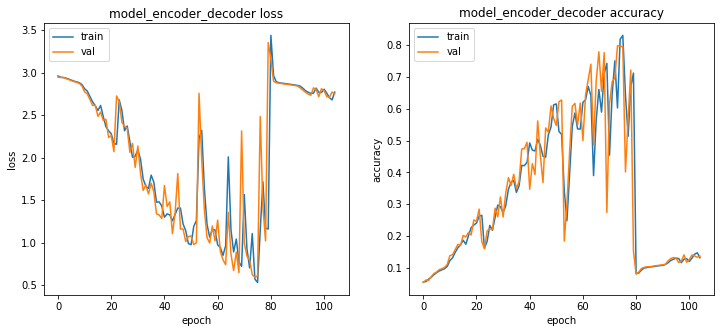

In [6]:
# training parameters
batch_size = 100

# model parameters
rnn_units = 150

# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=30)

Epoch 1/200
18/18 [==============================] - 145s 2s/step - loss: 2.9632 - accuracy: 0.0552 - val_loss: 2.9445 - val_accuracy: 0.0560
Epoch 2/200
18/18 [==============================] - 5s 287ms/step - loss: 2.9448 - accuracy: 0.0565 - val_loss: 2.9422 - val_accuracy: 0.0609
Epoch 3/200
18/18 [==============================] - 5s 284ms/step - loss: 2.9405 - accuracy: 0.0625 - val_loss: 2.9371 - val_accuracy: 0.0697
Epoch 4/200
18/18 [==============================] - 5s 280ms/step - loss: 2.9331 - accuracy: 0.0717 - val_loss: 2.9274 - val_accuracy: 0.0747
Epoch 5/200
18/18 [==============================] - 5s 277ms/step - loss: 2.9215 - accuracy: 0.0785 - val_loss: 2.9146 - val_accuracy: 0.0813
Epoch 6/200
18/18 [==============================] - 5s 275ms/step - loss: 2.9149 - accuracy: 0.0814 - val_loss: 2.9105 - val_accuracy: 0.0843
Epoch 7/200
18/18 [==============================] - 5s 279ms/step - loss: 2.9069 - accuracy: 0.0870 - val_loss: 2.9033 - val_accuracy: 0.0858


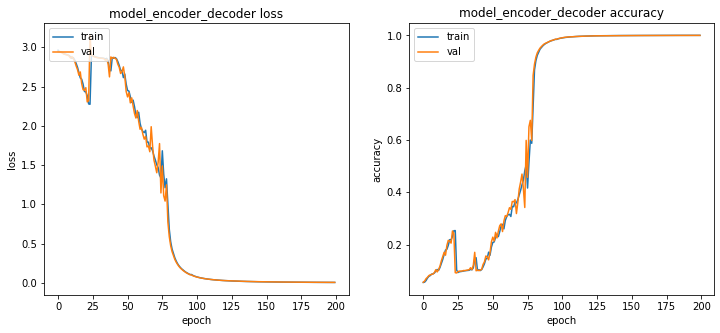

In [7]:
# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=50)

Epoch 1/200
18/18 [==============================] - 148s 2s/step - loss: 2.9659 - accuracy: 0.0537 - val_loss: 2.9474 - val_accuracy: 0.0540
Epoch 2/200
18/18 [==============================] - 5s 283ms/step - loss: 2.9455 - accuracy: 0.0553 - val_loss: 2.9437 - val_accuracy: 0.0589
Epoch 3/200
18/18 [==============================] - 5s 286ms/step - loss: 2.9416 - accuracy: 0.0603 - val_loss: 2.9362 - val_accuracy: 0.0711
Epoch 4/200
18/18 [==============================] - 5s 279ms/step - loss: 2.9345 - accuracy: 0.0705 - val_loss: 2.9286 - val_accuracy: 0.0717
Epoch 5/200
18/18 [==============================] - 5s 287ms/step - loss: 2.9302 - accuracy: 0.0749 - val_loss: 2.9254 - val_accuracy: 0.0760
Epoch 6/200
18/18 [==============================] - 5s 276ms/step - loss: 2.9220 - accuracy: 0.0794 - val_loss: 2.9168 - val_accuracy: 0.0822
Epoch 7/200
18/18 [==============================] - 5s 284ms/step - loss: 2.9149 - accuracy: 0.0822 - val_loss: 2.9110 - val_accuracy: 0.0858


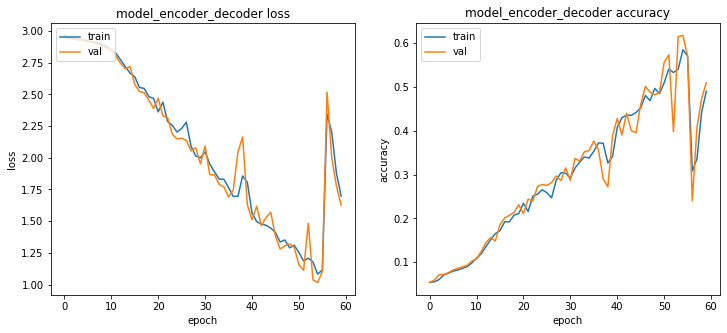

In [15]:
# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=5)

## Bahdanau Attention

The usual RNN, as implemented previously $h_t = f(x_i, h_{t-1})$, and with context vector $c = q(\{ h_1, \dots, h_{T_x}\})$, reads an input sequence $x$ in order starting from the first symbol $x_1$ to the last one $x_{T_x}$. However, in the proposed scheme, we would like the annotation of each word to summarize not only the preceding words, but also the following words. Therefore, in this model we consider the annotations $(h_1, \dots, h_n)$ forward and backward, this is:
$$ 
h_i = (  \overrightarrow{h_i},  \overleftarrow{h_i})^T
$$
Hence, we have a bidirectional RNN, in which each annotation represents the preceding and the following words. 

Now, the score is computed as follows:
$$score(h_t, \hat{h}_{s}) = \nu_a^T tanh(W_a[ h_t^T; \hat{h}_s])$$ for the **Balhdanau** attention

In [5]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        ##################
        # YOUR CODE HERE #
        ##################
        
        # we need the previous and following annotations
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        # Single hidden layer network model
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):

        ##################
        # YOUR CODE HERE #
        ##################

        query_with_time_axis = tf.expand_dims(query, 1)

        # Compute score according to Bahnadau's score formula
        
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # Normalize the score to compute the attention weights (softmax(score) = exp(score) / sum of all exp(score)s)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Now we may compute the context vector
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [9]:
# Train LuongDotAttention and retrieve model, encoder and decoders (to compare with our implementations)
#attention_ld = LuongDotAttention()
#model_attention= build_attention_model(attention, batch_size, rnn_units)
#train_test(model_attention, X_train, y_train , X_test,
#           y_test, batch_size=batch_size, epochs=50, patience=3)

In [10]:
# Train BahdanauAttention and retrieve model, encoder and decoders
attention_b = BahdanauAttention(rnn_units)
model_attention_b = build_attention_model(attention_b, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 159s 3s/step - loss: 2.9644 - accuracy: 0.0528 - val_loss: 2.9477 - val_accuracy: 0.0522
Epoch 2/200
18/18 [==============================] - 14s 766ms/step - loss: 2.9458 - accuracy: 0.0541 - val_loss: 2.9442 - val_accuracy: 0.0536
Epoch 3/200
18/18 [==============================] - 14s 769ms/step - loss: 2.9433 - accuracy: 0.0579 - val_loss: 2.9429 - val_accuracy: 0.0617
Epoch 4/200
18/18 [==============================] - 14s 763ms/step - loss: 2.9383 - accuracy: 0.0639 - val_loss: 2.9350 - val_accuracy: 0.0652
Epoch 5/200
18/18 [==============================] - 14s 759ms/step - loss: 2.9302 - accuracy: 0.0727 - val_loss: 2.9260 - val_accuracy: 0.0764
Epoch 6/200
18/18 [==============================] - 14s 765ms/step - loss: 2.9215 - accuracy: 0.0794 - val_loss: 2.9184 - val_accuracy: 0.0814
Epoch 7/200
18/18 [==============================] - 14s 769ms/step - loss: 2.9131 - accuracy: 0.0830 - val_loss: 2.9091 - val_accuracy: 0

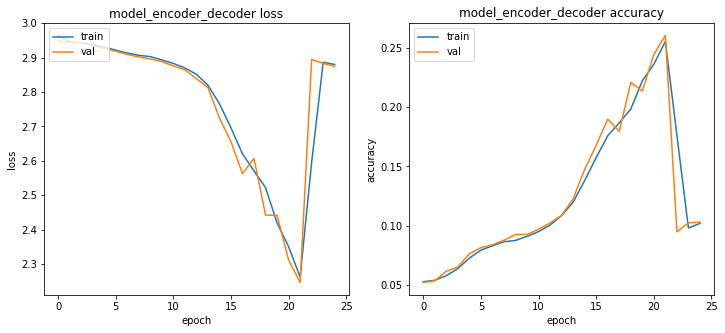

In [11]:
train_test(model_attention_b, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=3)

In [6]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        
        ##################
        # YOUR CODE HERE #
        ##################
        # We need to initialized all that is involved in the Luong's attention score formula
        # Only a weight matrix is needed
        self.W = tf.keras.layers.Dense(units)
        

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        ##################
        # YOUR CODE HERE #
        ##################

        # Compute score according to Bahnadau's score formula
        # score = tf.matmul(query_with_time_axis, self.W(values_transposed))
        score = tf.transpose(tf.matmul(query_with_time_axis, self.W(values_transposed)), perm=[0, 2, 1])
        # score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed), perm=[0, 2, 1])
   
        # Repeat the same routine as in Bahnadau's Attention implementation
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)


        return context_vector, attention_weights

In [13]:
# Train BahdanauAttention and retrieve model, encoder and decoders
attention_gen = LuongGeneralAttention(rnn_units)
model_attention_gen= build_attention_model(attention_gen, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 155s 2s/step - loss: 2.9635 - accuracy: 0.0537 - val_loss: 2.9472 - val_accuracy: 0.0524
Epoch 2/200
18/18 [==============================] - 12s 661ms/step - loss: 2.9453 - accuracy: 0.0563 - val_loss: 2.9430 - val_accuracy: 0.0562
Epoch 3/200
18/18 [==============================] - 12s 666ms/step - loss: 2.9409 - accuracy: 0.0621 - val_loss: 2.9380 - val_accuracy: 0.0701
Epoch 4/200
18/18 [==============================] - 12s 680ms/step - loss: 2.9365 - accuracy: 0.0711 - val_loss: 2.9281 - val_accuracy: 0.0735
Epoch 5/200
18/18 [==============================] - 12s 667ms/step - loss: 2.9201 - accuracy: 0.0813 - val_loss: 2.9066 - val_accuracy: 0.0914
Epoch 6/200
18/18 [==============================] - 12s 661ms/step - loss: 2.8943 - accuracy: 0.0934 - val_loss: 2.8811 - val_accuracy: 0.1014
Epoch 7/200
18/18 [==============================] - 12s 659ms/step - loss: 2.8702 - accuracy: 0.1040 - val_loss: 2.8616 - val_accuracy: 0

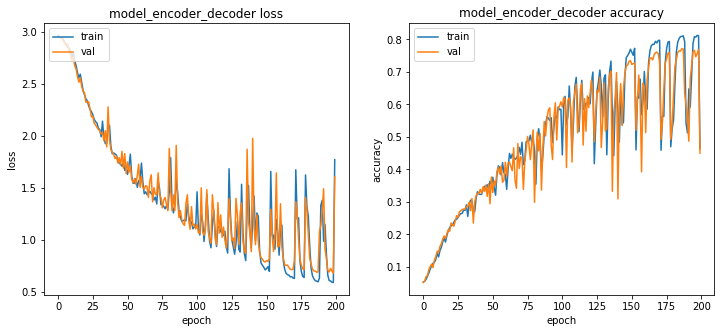

In [14]:
train_test(model_attention_gen, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=30)

## Wrap up configurations for each model:

2022-12-27 22:42:19.409753: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-12-27 22:44:14.510652: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 174s 3s/step - loss: 2.9644 - accuracy: 0.0541 - val_loss: 2.9474 - val_accuracy: 0.0580
Epoch 2/200
18/18 [==============================] - 14s 768ms/step - loss: 2.9452 - accuracy: 0.0562 - val_loss: 2.9437 - val_accuracy: 0.0625
Epoch 3/200
18/18 [==============================] - 14s 769ms/step - loss: 2.9406 - accuracy: 0.0620 - val_loss: 2.9361 - val_accuracy: 0.0665
Epoch 4/200
18/18 [==============================] - 14s 768ms/step - loss: 2.9315 - accuracy: 0.0706 - val_loss: 2.9274 - val_accuracy: 0.0710
Epoch 5/200
18/18 [==============================] - 14s 765ms/step - loss: 2.9225 - accuracy: 0.0770 - val_loss: 2.9194 - val_accuracy: 0.0792
Epoch 6/200
18/18 [==============================] - 14s 773ms/step - loss: 2.9156 - accuracy: 0.0818 - val_loss: 2.9127 - val_accuracy: 0.0824
Epoch 7/200
18/18 [==============================] - 14s 765ms/step - loss: 2.9075 - accuracy: 0.0859 - val_loss: 2.9045 - val_accuracy: 0.0838
Epoch 

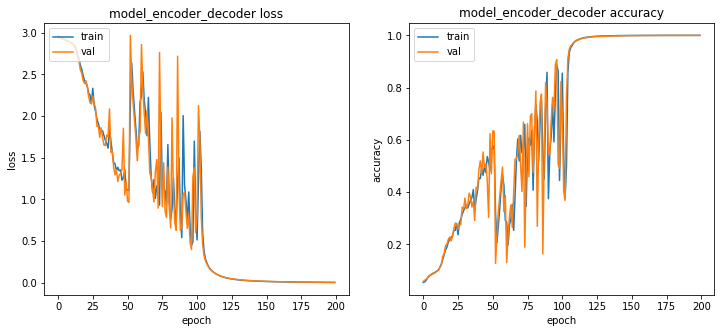

In [7]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

attention_b = BahdanauAttention(rnn_units)
model_attention_b, encoder_lstm_b, decoder_lstm_b, decoder_dense_b = build_attention_model(attention_b, batch_size, rnn_units)
train_test(model_attention_b, X_train, y_train , X_test, y_test, 
           batch_size=batch_size, epochs=200, patience=30)



#attention_b = BahdanauAttention(rnn_units)
#model_attention_b = build_attention_model(attention_b, batch_size, rnn_units)

#train_test(model_attention_b, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=50)

Epoch 1/200
18/18 [==============================] - 170s 3s/step - loss: 2.9648 - accuracy: 0.0514 - val_loss: 2.9462 - val_accuracy: 0.0532
Epoch 2/200
18/18 [==============================] - 14s 781ms/step - loss: 2.9446 - accuracy: 0.0561 - val_loss: 2.9424 - val_accuracy: 0.0644
Epoch 3/200
18/18 [==============================] - 14s 790ms/step - loss: 2.9421 - accuracy: 0.0640 - val_loss: 2.9405 - val_accuracy: 0.0578
Epoch 4/200
18/18 [==============================] - 14s 776ms/step - loss: 2.9371 - accuracy: 0.0678 - val_loss: 2.9358 - val_accuracy: 0.0660
Epoch 5/200
18/18 [==============================] - 14s 770ms/step - loss: 2.9288 - accuracy: 0.0748 - val_loss: 2.9218 - val_accuracy: 0.0776
Epoch 6/200
18/18 [==============================] - 14s 774ms/step - loss: 2.9195 - accuracy: 0.0804 - val_loss: 2.9141 - val_accuracy: 0.0834
Epoch 7/200
18/18 [==============================] - 14s 770ms/step - loss: 2.9118 - accuracy: 0.0838 - val_loss: 2.9060 - val_accuracy: 0

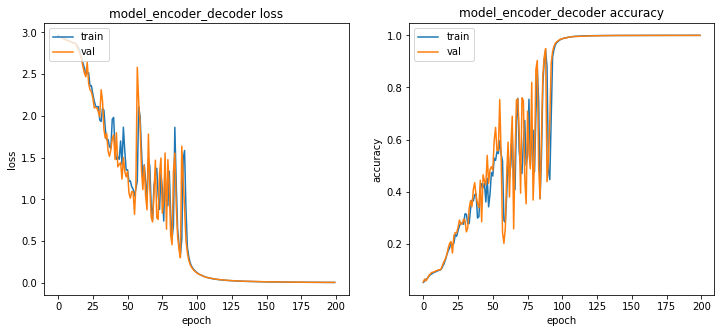

In [8]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

attention_b = BahdanauAttention(rnn_units)
model_attention_b, encoder_lstm_b, decoder_lstm_b, decoder_dense_b = build_attention_model(attention_b, batch_size, rnn_units)
train_test(model_attention_b, X_train, y_train , X_test, y_test, 
           batch_size=batch_size, epochs=200, patience=20)




Epoch 1/200
18/18 [==============================] - 215s 2s/step - loss: 2.9653 - accuracy: 0.0549 - val_loss: 2.9470 - val_accuracy: 0.0542
Epoch 2/200
18/18 [==============================] - 12s 677ms/step - loss: 2.9447 - accuracy: 0.0565 - val_loss: 2.9436 - val_accuracy: 0.0586
Epoch 3/200
18/18 [==============================] - 12s 675ms/step - loss: 2.9404 - accuracy: 0.0635 - val_loss: 2.9357 - val_accuracy: 0.0700
Epoch 4/200
18/18 [==============================] - 12s 666ms/step - loss: 2.9318 - accuracy: 0.0735 - val_loss: 2.9303 - val_accuracy: 0.0704
Epoch 5/200
18/18 [==============================] - 12s 667ms/step - loss: 2.9207 - accuracy: 0.0819 - val_loss: 2.9101 - val_accuracy: 0.0860
Epoch 6/200
18/18 [==============================] - 12s 668ms/step - loss: 2.8961 - accuracy: 0.0927 - val_loss: 2.8851 - val_accuracy: 0.0969
Epoch 7/200
18/18 [==============================] - 12s 677ms/step - loss: 2.8725 - accuracy: 0.1019 - val_loss: 2.8746 - val_accuracy: 0

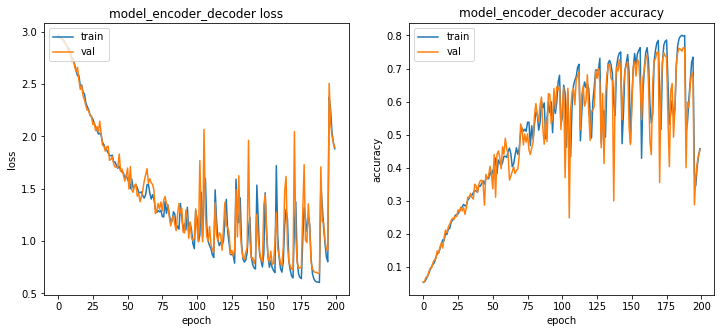

In [9]:
# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention_lg = LuongGeneralAttention(rnn_units)
model_attention_gen, encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg = build_attention_model(attention_lg, batch_size, rnn_units)
#attention_gen = LuongGeneralAttention(rnn_units)
#model_attention_gen= build_attention_model(attention_gen, batch_size, rnn_units)
#training
train_test(model_attention_gen, X_train, y_train , X_test, y_test, 
           batch_size=batch_size, epochs=200, patience=50)
#train_test(model_attention_gen, X_train, y_train , X_test,
           #y_test, batch_size=batch_size, epochs=200, patience=50)

Epoch 1/200
18/18 [==============================] - 147s 2s/step - loss: 2.9664 - accuracy: 0.0518 - val_loss: 2.9461 - val_accuracy: 0.0508
Epoch 2/200
18/18 [==============================] - 5s 285ms/step - loss: 2.9450 - accuracy: 0.0556 - val_loss: 2.9440 - val_accuracy: 0.0612
Epoch 3/200
18/18 [==============================] - 5s 283ms/step - loss: 2.9427 - accuracy: 0.0613 - val_loss: 2.9386 - val_accuracy: 0.0645
Epoch 4/200
18/18 [==============================] - 5s 288ms/step - loss: 2.9367 - accuracy: 0.0684 - val_loss: 2.9316 - val_accuracy: 0.0719
Epoch 5/200
18/18 [==============================] - 5s 278ms/step - loss: 2.9361 - accuracy: 0.0701 - val_loss: 2.9342 - val_accuracy: 0.0741
Epoch 6/200
18/18 [==============================] - 5s 289ms/step - loss: 2.9294 - accuracy: 0.0737 - val_loss: 2.9263 - val_accuracy: 0.0762
Epoch 7/200
18/18 [==============================] - 5s 289ms/step - loss: 2.9214 - accuracy: 0.0800 - val_loss: 2.9139 - val_accuracy: 0.0861


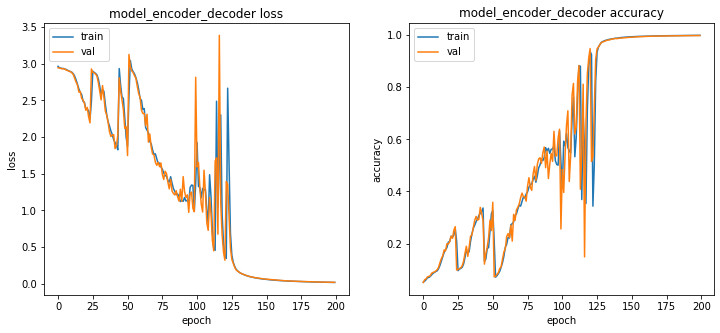

In [9]:
# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention_l = LuongDotAttention()
model_attention_l, encoder_lstm_l, decoder_lstm_l, decoder_dense_l = build_attention_model(attention_l, batch_size, rnn_units)
#attention_gen = LuongGeneralAttention(rnn_units)
#model_attention_gen= build_attention_model(attention_gen, batch_size, rnn_units)
#training
train_test(model_attention_l, X_train, y_train , X_test, y_test, 
           batch_size=batch_size, epochs=200, patience=40)

In [ ]:
# training parameters
batch_size = 70

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm_l, decoder_lstm_l, decoder_dense_l = build_attention_model(attention, batch_size, rnn_units)
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=50)

## Weight visualization

In [10]:
def evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  # Initialize the attention plotting for visualization and enconde input sequence
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  sequence = one_hot_encode(seq_in,n_features)

  # ENCODER STEP (Remember we don't need to initialize it because they are given)
  encoder_inputs = np.array(sequence).reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  states = [encoder_state_h, encoder_state_c]

  all_outputs = []

  # DECODER STEP
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 
  inputs = decoder_input_data
  decoder_outputs = encoder_state_h

  # Same loop as in build_attention_model. Decoder will only process one timestep at a time.
  for t in range(n_timesteps_in):
      # Pay attention
      # Create the context vector by applying attention to the outputs.
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      # Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      # Storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()
      
      # Passing the concatenated vector to the LSTM
      # Run the decoder on one timestep and previous states
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, encoder_state_h, encoder_state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      # Use the last hidden state for prediction the output, save the current prediction
      # Predictions will be concatenated later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      # Reinject the outputs as inputs for the next loop iteration as well as update the states
      inputs = outputs
      states = [encoder_state_h, encoder_state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])
  
  return seq_in, seq_out, attention_plot

In [11]:
import matplotlib.ticker as ticker

def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(16,16))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  # add labels
  fontdict = {'fontsize': 10}
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()



In [12]:
def translate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  seq_in, seq_out, attention_plot = evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)
  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


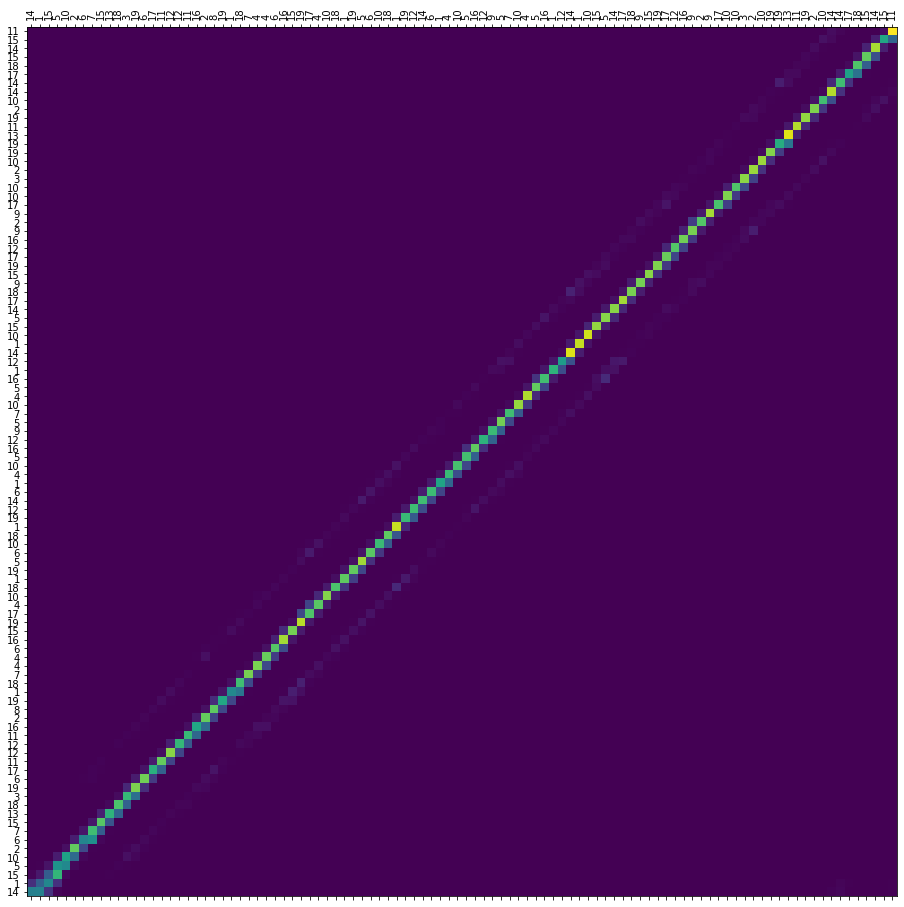

In [13]:
# Plot for each one of the models (LuongDot, LuongGeneral, Bahdanau)
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_l, decoder_lstm_l, decoder_dense_l, attention_l)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


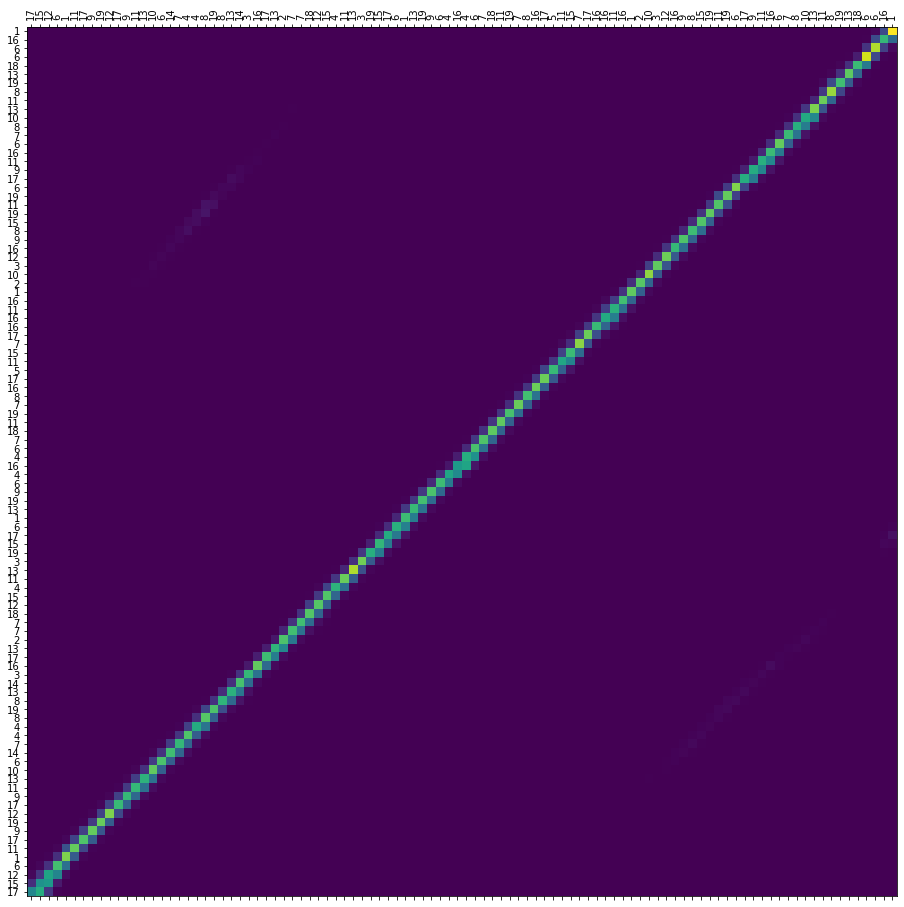

In [14]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_b, decoder_lstm_b, decoder_dense_b, attention_b)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


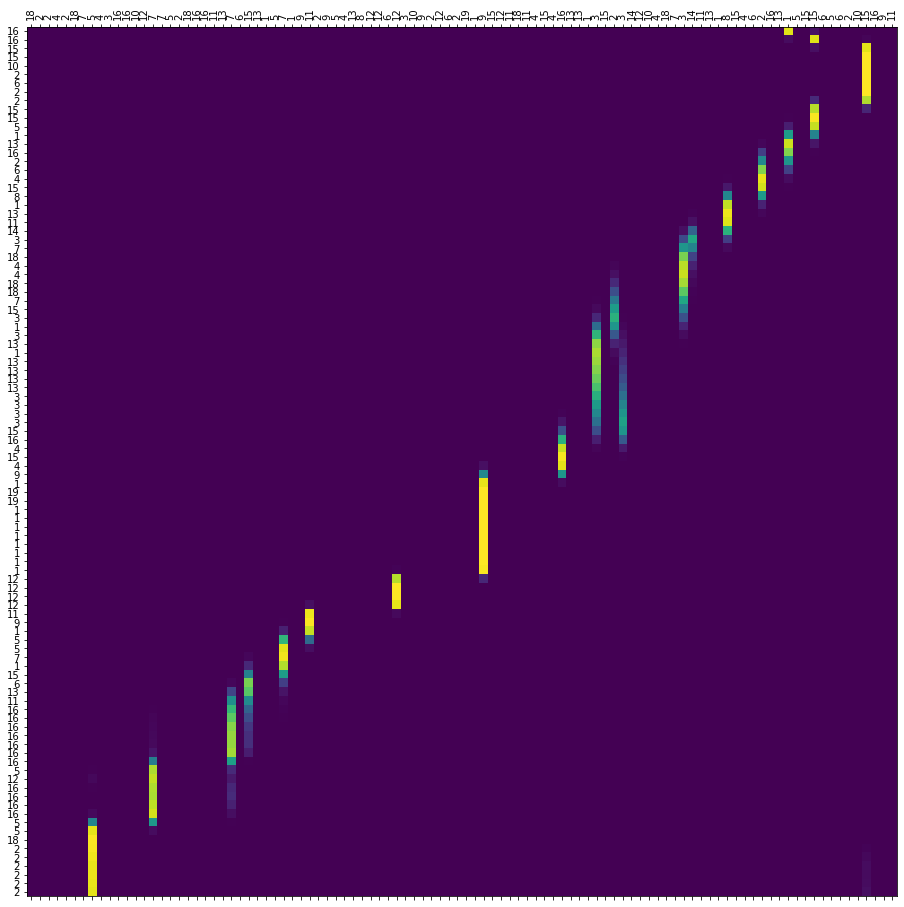

In [13]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg, attention_lg)

# Comparative:

| Epochs  | Patience  | batch size  | rnn units  | Method  | Train acc | Test acc |
|---|---|---|---|---|---|---|
| 143  | 30  | 100  | 100  | Luong  | 93.093 | 93.675  |  
| 86  | 30  | 50  | 100  | Luong  | 96.438 | 95.685 |  
| 100  | 30  | 100  | 100  | Luong  | 90.074 | 89.910 |
| 105  | 30  | 100  | 150  | Luong  | 80.257 | 78.455 |
| 200  | 40  | 100  | 100  | Luong  | 99.898 | 99.855|
| 200  | 50  | 100  | 100  | Luong  | 99.995 | 99.935 |
| 60  | 5  | 100  | 100  | Luong  |64.507 | 62.095 |
| 25  | 3  | 100  | 100  | Bahdanau  | 25.900 | 25.920 |
| 128  | 50  | 100  | 100  | Bahdanau  | 81.718 | 81.325 |
| 200  | 30  | 100  | 100  | Bahdanau  | 99.995 | 99.970 |
| 200  | 20  | 100  | 100  | Bahdanau  | 99.998 | 99.990 |
| 200  | 30  | 100  | 100  | Luong General  | 46.171 | 45.180 |
| 200  | 50  | 100  | 100  | Luong General | 46.746 | 45.225 |


Note that by adjusting the number of epochs and the patience parameter we can attain almost 1 accuracy values for the Luong dot and Bahdanau model, evidencing the effictiviness of both models. However, when studying the Luong general model it is harder to get good accuracy levels. This could be due to the fact that when considering highier number of epochs with high patience levels then we tend to overfit the model, especially when considering the general model, which uses the whole sequence for each step. 

Additionally, for fixed values of epochs and patience, when reducing by half the batch size, more accurate results are obtained, since when considering highier bathc sizes we tend to compute approximations and be less specific per element on the training set. Finally, increasing rnn units we obtain worse results, which may be explained by overfitting the model again.

## Blog site link:

https://hackmd.io/@FlaviaFerrus/HyyFrLRds